# Solving the heat equation in PyBaMM

In this notebook we create and solve a model for unsteady heat diffusion in 1D, with a spatially dependent heat soure term. The notebook is adapted from example 4.1.2 on pg.16 of the onlines notes found [here](https://faculty.uca.edu/darrigo/Students/M4315/Fall%202005/sep-var.pdf). 

We consider the heat equation 

$$T_{t} = kT_{xx} + Q(x), \quad 0 < x < L, \quad t > 0,$$

along with the boundary and initial conditions, 

$$u(0, t)=0, \quad u(L, t)=0, \quad u(x, 0)=2x-x^2,$$

and heat source term 

$$ Q(x)=1-|x-1|.$$

As in the example, we solve the problem on the domain $0 < x < 2$ (i.e. we take $L=2$). We extended the example to include a thermal diffusivity $k$, which we take to be equal to 0.75.

## Building the model
As always, we start by importing PyBaMM, along with any other packages we require.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

We then load up an instance of the `pybamm.BaseModel` class.

In [2]:
model = pybamm.BaseModel()

We now define the model variables and parameters. Note that we also need to define the spatial variable $x$ here, so that we can write down the spatially dependent source term $Q(x)$. Since we are solving in 1D we have decided to call the domain "rod", but we could name it anything we like. Note that in PyBaMM variables and parameters can be given useful and meaningful names, such as "Temperature", so that they can be easily referred to later.

In [3]:
x = pybamm.SpatialVariable("x", domain="rod", coord_sys="cartesian")
T = pybamm.Variable("Temperature", domain="rod")
k = pybamm.Parameter("Thermal diffusivity")

Now that we have defined the variables, we can write down the model equations and add them to the `model.rhs` dictionary. This dictionary stores the right hand sides of any time-dependent differential equations (ordinary or partial). The key is the variable inside the time derivative (in this case $T$). To define the heat source term we use a `pybamm.Function` class. The first argument of the class is the function, and the second argument is the input.  

In [4]:
N = -k * pybamm.grad(T)  # Heat flux
Q = 1 - pybamm.Function(np.abs, x - 1)  # Source term
dTdt = -pybamm.div(N) + Q  # The right hand side of the PDE
model.rhs = {T: dTdt}  # Add to model

We now add the boundary conditions into the `model.boundary_conditions` dictionary. The keys of the dictionary indicate which end of the boundary the condition is applied to (in 1D this can be "left" or "right"), the entry is then give as a tuple of the value and type. In this example we have homogeneous Dirichlet boundary conditions at both ends.

In [5]:
model.boundary_conditions = {
    T: {
        "left": (pybamm.Scalar(0), "Dirichlet"),
        "right": (pybamm.Scalar(0), "Dirichlet"),
    }
}

We also need to add the initial conditions to the `model.initial_conditions` dictionary.

In [6]:
model.initial_conditions = {T: 2 * x - x ** 2}

Finally, we add any output variables to the `model.variables` dictionary. These variables can be easily accessed after the model has been solved. You can add any variables of interest to this dictionary. Here we have added the temperature, heat flux and heat source.

In [7]:
model.variables = {"Temperature": T, "Heat flux": N, "Heat source": Q}

## Using the model
Now that the model has been constructed we can go ahead and define our geometry and parameter values. We start by defining the geometry for our "rod" domain. We need to set the so-called "primary" variable, which is the spatial direction(s) in which spatial operators act (such as gradients). In this case it is simply $x$. We then set the minimum and maximum values $x$ can take. In this example we are solving the problem on the domain $0<x<2$.

In [8]:
geometry = {"rod": {"primary": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(2)}}}}

We also need to provide the values of any parameters using the `pybamm.ParameterValues` class. This class accepts a dictionary of parameter names and values. Note that the name we provide is the string name of the parametrs and not its symbol.

In [9]:
param = pybamm.ParameterValues({"Thermal diffusivity": 0.75})

Now that we have defined the geometry and provided the parameters values, we can process the model.

In [10]:
param.process_model(model)
param.process_geometry(geometry)

Before we disctretise the spatial operators, we must choose and mesh and a spatial method. Here we choose to use a uniformly spaced 1D mesh with 30 points, and discretise the equations in space using the finite volume method. The information about the mesh is stored in a `pybamm.Mesh` object, wheres the spatial methods are stored in a dictionary which maps domain names to a spatial method. This allows the user to discretise different (sub)domains in a problem using different spatial methods. All of this information goes into a `pybamm.Discretisation` object, which accepts a mesh and a dictionary of spatial methods.

In [11]:
submesh_types = {"rod": pybamm.Uniform1DSubMesh}
var_pts = {x: 30}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"rod": pybamm.FiniteVolume}
disc = pybamm.Discretisation(mesh, spatial_methods)

The model is then processed using the discretisation, turning the spaital operators into matrix-vector multiplications.

In [12]:
disc.process_model(model)

Now that the model has been discretised we are ready to solve. We must first choose a solver to use. For this model we choose the Scipy ODE solver, but other solvers are available in PyBaMM (see [here](https://pybamm.readthedocs.io/en/latest/source/solvers/index.html)). To solve the model, we use the method `solver.solve` which takes in a model and an array of times at which we would like the solution to be returned. Ths solution is then stored in the `solution` object. The times and states can be accessed with `solver.t` and `solver.y`.

In [13]:
solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(model, t)

After solving, we can process variables using the class `pybamm.ProcessedVariable`. This returns a callable object which can be evaluated and any time and position by means of interpolating the solution. Processed variables provide a convinient way of comparing the solution to solutions from different models, or to exact solutions. Since all of the variables are names with informative strings, the user doesn't need to keep track of where they are stored in the state vector `solution.y`. This is particularly useful in complex models with lots of variables. Here we create `T_out` which is the processed temperature. In order to do so, we pass the variable, solution times, soltuion states, and the mesh to `pybamm.ProcessedVariable`.

In [14]:
T_out = pybamm.ProcessedVariable(model.variables["Temperature"], solution.t, solution.y, mesh)

## Comparison with the exact solution

This example admits the exact solution 

$$T(x,t) = \sum_{n=1}^{\infty} \left(\frac{4}{kn^2\pi^2}q_n + \left( c_n - \frac{4}{kn^2\pi^2}q_n\right) \exp^{-k\left(\frac{n\pi}{2}\right)^2t} \right) \sin\left( \frac{n\pi x}{2}\right),$$

with 

$$c_n = \frac{16}{n^3\pi^3}\left(1 - \cos(n \pi)\right), \quad \text{and} \quad q_n = \frac{8}{n^2\pi^2} \sin\left(\frac{n\pi}{2}\right).$$


We construct the exact solution by summing over some large number $N$ of terms in the Fourier series.

In [15]:
N = 100  # number of Fourier modes to sum
k_val = param["Thermal diffusivity"]  # extract value of diffusivity from the parameters dictionary


# Fourier coefficients
def q(n):
    return (8 / (n ** 2 * np.pi ** 2)) * np.sin(n * np.pi / 2)


def c(n):
    return (16 / (n ** 3 * np.pi ** 3)) * (1 - np.cos(n * np.pi))


def b(n):
    return c(n) - 4 * q(n) / (k_val * n ** 2 * np.pi ** 2)


def T_n(t, n):
    return (4 * q(n) / (k_val * n ** 2 * np.pi ** 2)) + b(n) * np.exp(
        -k_val * (n * np.pi / 2) ** 2 * t
    )


# Sum series to get the temperature
def T_exact(x, t):
    out = 0
    for n in np.arange(1, N):
        out += T_n(t, n) * np.sin(n * np.pi * x / 2)
    return out

Finally, we plot the numerical and exact solutions at a series of different times. The plot demonstrates an excellent agreement between the numerical solution provided by PyBaMM (dots) and the exact solution (solid lines). Note that in the finite volume method the variable is evaluated at the cell centres.

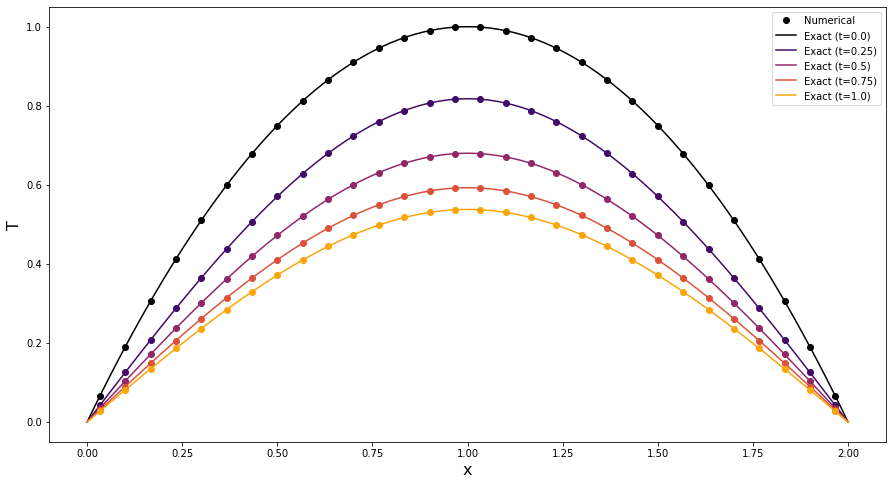

In [16]:
x_nodes = mesh["rod"][0].nodes  # numerical gridpoints
xx = np.linspace(0, 2, 101)  # fine mesh to plot exact solution
plot_times = np.linspace(0, 1, 5)  # times at which to plot

plt.figure(figsize=(15, 8))
cmap = plt.get_cmap("inferno")
for i, t in enumerate(plot_times):
    color = cmap(float(i) / len(plot_times))
    plt.plot(
        x_nodes,
        T_out(t, x=x_nodes),
        "o",
        color=color,
        label="Numerical" if i == 0 else "",
    )
    plt.plot(
        xx,
        T_exact(xx, t),
        "-",
        color=color,
        label="Exact (t={})".format(plot_times[i]),
    )
plt.xlabel("x", fontsize=16)
plt.ylabel("T", fontsize=16)
plt.legend()
plt.show()